In [1]:
#I used this link to understand what to do https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])
dataset1 = datasets.MNIST('.', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('.', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=True)

In [5]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1)

In [6]:
#training model
losses = []
accuracies = []
model.train()
for epoch in range(4):
    loss_sum = 0
    acc = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data
        pred = output.data.max(1, keepdim=True)[1]
        acc += pred.eq(target.data.view_as(pred)).sum()
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      loss_sum / len(train_loader.dataset), acc, len(train_loader.dataset), 100 * acc / len(train_loader.dataset))
    )
    losses.append(loss_sum)
    accuracies.append(acc)
    scheduler.step()


Test set: Avg. loss: 0.0082, Accuracy: 50516/60000 (84%)


Test set: Avg. loss: 0.0044, Accuracy: 54954/60000 (92%)


Test set: Avg. loss: 0.0042, Accuracy: 55214/60000 (92%)


Test set: Avg. loss: 0.0042, Accuracy: 55172/60000 (92%)



In [7]:
def fgsm_attack(image, epsilon, grad):
    sign_grad = grad.sign()
    perturbed_image = image + epsilon * sign_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [8]:
def test(epsilon):
    correct = 0
    adv_examples = []
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred != target:
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred == target:
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / len(test_loader)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [9]:
#testing and attacking model. eps = 0 -- original test accuracy without attack. The more epsilon, the more changes in picture.
accuracies = []
examples = []
epsilons = [0, .1, .2, .3, .4, .5, .6, .7]
for eps in epsilons:
    acc, ex = test(eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9324 / 10000 = 0.9324
Epsilon: 0.1	Test Accuracy = 9257 / 10000 = 0.9257
Epsilon: 0.2	Test Accuracy = 9122 / 10000 = 0.9122
Epsilon: 0.3	Test Accuracy = 8970 / 10000 = 0.897
Epsilon: 0.4	Test Accuracy = 8738 / 10000 = 0.8738
Epsilon: 0.5	Test Accuracy = 8001 / 10000 = 0.8001
Epsilon: 0.6	Test Accuracy = 6302 / 10000 = 0.6302
Epsilon: 0.7	Test Accuracy = 4298 / 10000 = 0.4298


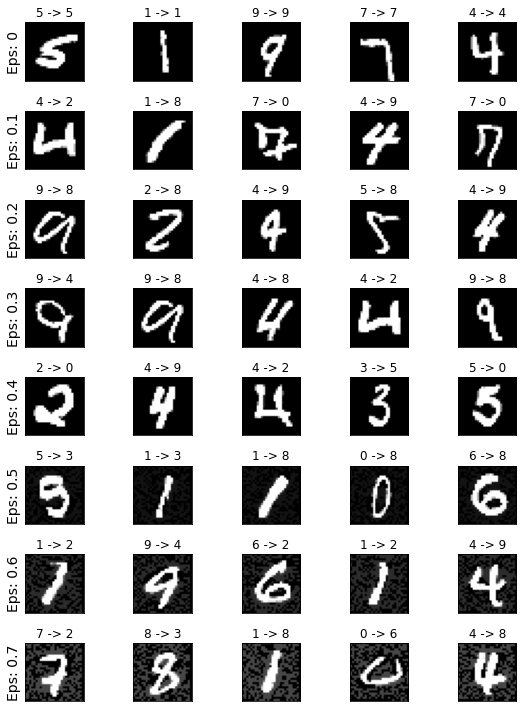

In [10]:
import matplotlib.pyplot as plt
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()